# Introduction

## Background
Text classification is a pivotal tool in natural language processing. Its applications include sentiment analysis, topic classification, and spam filtering. In the field of human resources and talent acquisition, accurately classifying job ads is crucial for efficient recruitment, talent matching, improved job search experiences for applicants, and labor market analysis. By automating the categorization of postings on job boards, organizations can streamline their hiring processes, enhance candidate experience, and gain valuable insights into workforce trends. The increase in popularity and presence of online job boards has lead to an overwhelming volume of job posts. Manually categorizing these postings into relevant job categories can be time-consuming and error prone. Sometimes the classifications are unintuitive leading applicants to miss out on great opportunities. This has created demand for accurate, automated solutions. This project aims to create a robust text classification model to categorize job descriptions into predetermined job categories.

## Research Problem
This research aims to develop a robust text classification model capable of automatically assigning accurate job categories from a predefined list to a large dataset of job descriptions. The model will leverage machine learning techniques to extract meaningful features from job descriptions and classify them into predefined categories. The challenges include handling a large unlabeled dataset, determining meaningful job categories, and ensuring high classification accuracy. Additionally, the research will focus on optimizing the model to manage diverse job descriptions and improving its performance through iterative self-training and domain expert consultation. The goal is to create a highly efficient and accurate job classification model that can significantly aid in organizing and retrieving job-related information.

## Objectives
1. Develop a text classification model based on the support vector machine (SVM) algorithm that assigns predefined job category labels to the corresponding job descriptions.
2. Use the same SVM model in a semi-supervised process known as self-training  to transform a subset the original unlabeled dataset into a labeled dataset that includes at least 5000 rows. 
3. Iteratively train the model on new chunks of data to accurately categorize job descriptions into the top 6 of the initial 16 predefined categories (targets) based on their text content.
4. Achieve a classification accuracy of at least 80% ensuring that the model reliably differentiates the job categories.

## Hypothesis
Null hypothesis: HR, IT, and Marketing are not the categories that are highest in demand. 

Alternative hypothesis: HR, IT, and Marketing are the categories that are highest in demand.

# Methodology, Results, and Discussion

In [1]:
# Uncomment to install the following required packages
# pip pandas numpy scikit-learn nltk matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import re as regex
import nltk
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.semi_supervised import LabelPropagation
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from pathlib import Path

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load data
There are 2 sets of labeled data (more details in the *Data Description* section below):
1. Sample dataset - the first 1000 job descriptions classified into the original 16 job categories
2. Final dataset - n job descriptions classified into the final 5 job descriptions

In [3]:
def load_sample_labeled_data():
    data_folder_name = 'data'
    sample_labeled_data_file_name = 'sample_labeled_data.csv'
    
    sample_labeled_data_file_path = os.path.join(os.getcwd(), data_folder_name, sample_labeled_data_file_name)
    
    return pd.read_csv(sample_labeled_data_file_path)

original_sample_labeled_data = load_sample_labeled_data()
original_sample_labeled_data.shape

(1521, 5)

In [4]:
def load_final_labeled_data():
    data_folder_name = 'data'
    final_labeled_data_file_name = 'final_labeled_data.csv'
    
    final_labeled_data_file_path = os.path.join(os.getcwd(), data_folder_name, final_labeled_data_file_name)
    
    return pd.read_csv(final_labeled_data_file_path)

original_final_labeled_data = load_final_labeled_data()
original_final_labeled_data.shape

(5329, 5)

**Toggle to choose whether to load the sample or final labeled data**

In [5]:
is_final_data = True

In [6]:
def load_labeled_data(should_load_final_data):
    if should_load_final_data:
        return original_final_labeled_data
    else:
        return original_sample_labeled_data

original_labeled_df = load_labeled_data(is_final_data)

## Data description 
The dataset used was sourced from a public job ads website. The exercise was done between 1st and 14th July 2024. The website provides a vast repository of job descriptions across diverse industries and roles. As of the time of this writing, the ads span a comprehensive period from January 2018 to July 2024. This ensures a rich representation of the job market over time. A custom Python web scraping script was developed to extract relevant job post information from the site. This script (present after the *Conclusion* section on this notebook and labeled as **Supplementary Work A**) iterated through multiple pages extracting key fields including job title, job description, page url, and date of posting. The raw dataset consisted of 59,986 unlabeled records. The data was collected under conditions that adhered to general web scraping ethics, ensuring ethical and legal compliance. Aside from not recording job descriptions comprising more than 10000 characters, no other constraints or limitations were imposed on the scraping process, allowing for a broad and unbiased dataset. *It's important to note that the website's structure and content may have undergone changes during the data collection period, which could potentially impact the dataset's consistency.* 3 HR professionals were consulted to create meaningful buckets which formed the initial 16 categories which were later reduced to 6.

In [7]:
original_labeled_df.head(3)

,TITLE,LINK,JOB DESCRIPTION,DATE,CATEGORY
0,Tuskys Supermarket Are Hiring,https://opportunitiesforyoungkenyans.co.ke/201...,"This last week of January, Tuskys supermarket ...",1/26/2018,Other
1,Admin Assistant Job Opportune,https://opportunitiesforyoungkenyans.co.ke/201...,We are looking to hire an administrative assis...,1/25/2018,"Admin, HR, CS, Office Support"
2,KPC Hiring Graduate Trainees,https://opportunitiesforyoungkenyans.co.ke/201...,MANAGEMENT TRAINEE Vacancy Reference: MANAGEME...,1/24/2018,"Internships, Fellowships, Scholarships"


In [8]:
# Initial 16 categories from the sample labeled data
original_sample_labeled_data['CATEGORY'].value_counts()

CATEGORY
Unknown                                   631
Internships, Fellowships, Scholarships    173
Admin, HR, CS, Office Support             115
Marketing, Sales                           94
Media & Communication                      92
Finance, Accounting                        73
Information Technology                     71
Social Services                            34
Transport, Logistics                       32
Hospitality, Tourism                       32
Construction, Artisans, SkilledTrade       31
Legal, Security, Law Enforcement           31
Healthcare, Medical                        29
Education, Training                        29
Entertainment, Arts, Sports                25
Science, Research                          24
Media & Communication                       4
Name: count, dtype: int64

In [9]:
# Final 6 categories from the final labeled data
original_final_labeled_data['CATEGORY'].value_counts()

CATEGORY
Other                                     3171
Internships, Fellowships, Scholarships     798
Admin, HR, CS, Office Support              536
Finance, Accounting                        322
Marketing, Sales                           261
Information Technology                     241
Name: count, dtype: int64

## Exploratory data analytics 

In [10]:
original_labeled_df.shape

(5329, 5)

In [11]:
original_labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TITLE            5329 non-null   object
 1   LINK             5329 non-null   object
 2   JOB DESCRIPTION  5329 non-null   object
 3   DATE             5329 non-null   object
 4   CATEGORY         5329 non-null   object
dtypes: object(5)
memory usage: 208.3+ KB


## Data cleaning / pre-treatment for ML
Data cleaning involved handling missing values and removing duplicates. 

Missing values were caused by deliberately omitting descriptions which only included images and those whose content exceeded a character count of 10,000. Text preprocessing included lemmatization to normalize the text and the use of Term Frequency-Inverse Document Frequency (TF-IDF) for feature engineering.

### Check for missing values

In [12]:
def remove_missing_values(df):
    missing_values = df.isnull().sum()
    print(f'Total missing values before cleaning: \n{missing_values}\n')
    
    clean_df = df.dropna()
    print(f'Total missing values after cleaning: \n{clean_df.isnull().sum()}\n')
    
    return clean_df

### Removing Duplicates

In [13]:
def remove_duplicates(df):
    duplicates = df[df['JOB DESCRIPTION'].duplicated(keep='first')]['JOB DESCRIPTION']
    print(f'Total duplicated records: \n{duplicates.count()}\n')

    clean_df = df.drop_duplicates(subset='JOB DESCRIPTION', keep='first')
    print(f'Total unique records: \n{clean_df.count()}\n')
    
    return clean_df

### Cleaning data

In [14]:
def clean_data(df):
    labeled_df_without_missing_values = remove_missing_values(df)
    return remove_duplicates(labeled_df_without_missing_values)

labeled_df = clean_data(original_labeled_df)

Total missing values before cleaning: 
TITLE              0
LINK               0
JOB DESCRIPTION    0
DATE               0
CATEGORY           0
dtype: int64

Total missing values after cleaning: 
TITLE              0
LINK               0
JOB DESCRIPTION    0
DATE               0
CATEGORY           0
dtype: int64

Total duplicated records: 
801

Total unique records: 
TITLE              4528
LINK               4528
JOB DESCRIPTION    4528
DATE               4528
CATEGORY           4528
dtype: int64



In [15]:
def clean_category_data(text):
  text = text.lstrip().rstrip()
  return text

cleaned_original_labeled_df = labeled_df.copy()
clean_category_data = cleaned_original_labeled_df['CATEGORY'].apply(clean_category_data)
cleaned_original_labeled_df['CATEGORY'] = clean_category_data

In [16]:
cleaned_original_labeled_df['CATEGORY'].value_counts()

CATEGORY
Other                                     2684
Internships, Fellowships, Scholarships     613
Admin, HR, CS, Office Support              463
Finance, Accounting                        299
Marketing, Sales                           248
Information Technology                     221
Name: count, dtype: int64

In [17]:
cleaned_labeled_df = cleaned_original_labeled_df.iloc[:, [2, 4]]
cleaned_labeled_df.head(3)

,JOB DESCRIPTION,CATEGORY
0,"This last week of January, Tuskys supermarket ...",Other
1,We are looking to hire an administrative assis...,"Admin, HR, CS, Office Support"
2,MANAGEMENT TRAINEE Vacancy Reference: MANAGEME...,"Internships, Fellowships, Scholarships"


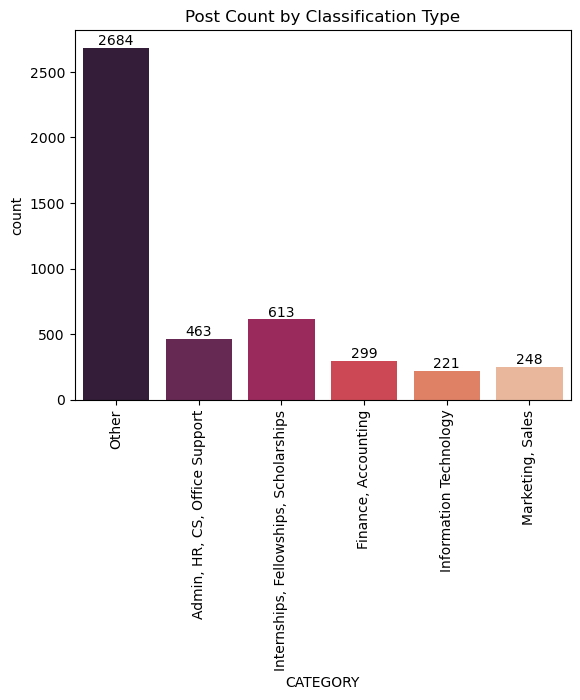

In [18]:
defined_categories = cleaned_labeled_df['CATEGORY'][cleaned_labeled_df['CATEGORY'] != 'Unknown']

ax = sns.countplot(x = defined_categories, palette = 'rocket', hue = defined_categories, legend = False)

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=90)
plt.title("Post Count by Classification Type")
plt.show()

In [19]:
def preprocess_text(text, custom_stopwords):
  text = regex.sub('[^a-zA-Z]', ' ', text).lower()
 
  words = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  stop_words.update(custom_stopwords)

  words = [word for word in words if word not in stop_words]

  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in words]

  text = ' '.join(words)
  return text

In [20]:
custom_stopwords = ['kenya', 'job', 'application', 'apply', 'email', 'year', 'work', 'skill', 'position', 'ensure', 'kenya', 'http', 'candidate', 'program', 'staff', 'www', 'cv', 'experience']
df = cleaned_labeled_df.copy()
df['Cleaned Job Description'] = df['JOB DESCRIPTION'].apply(preprocess_text, custom_stopwords=custom_stopwords)

### Word Frequency Analysis

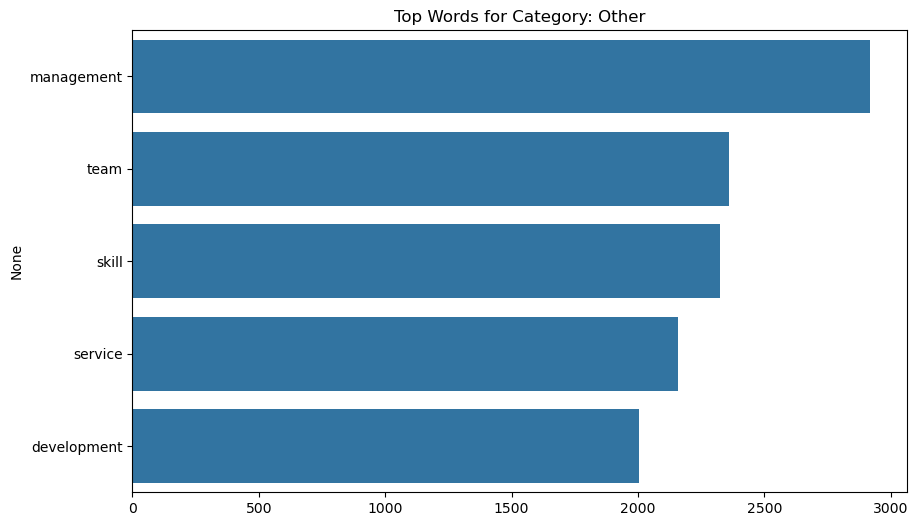

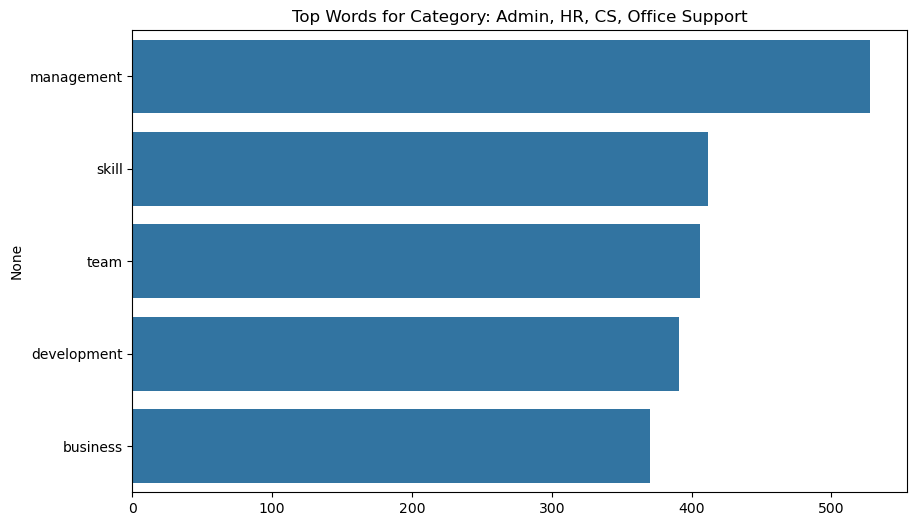

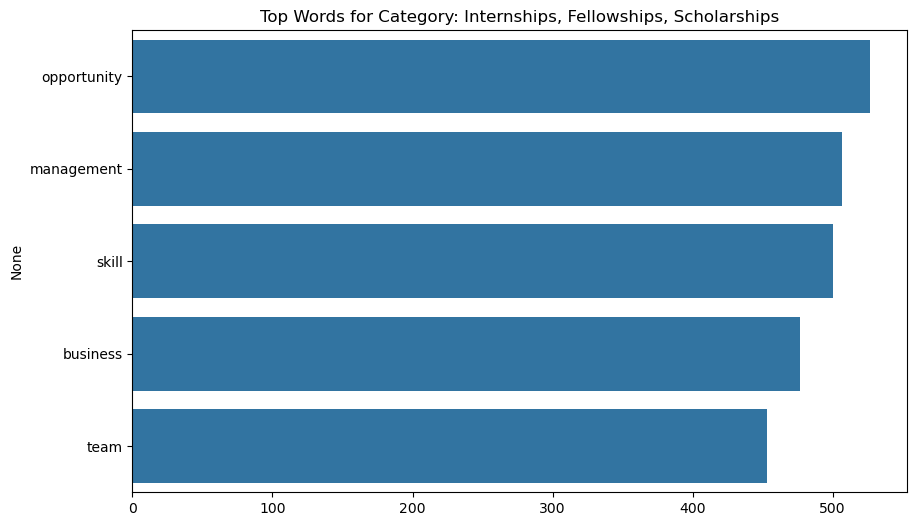

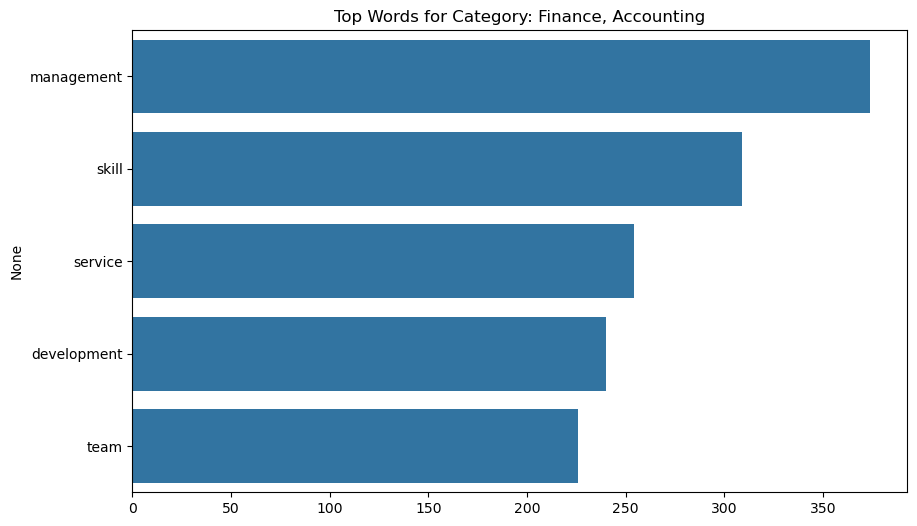

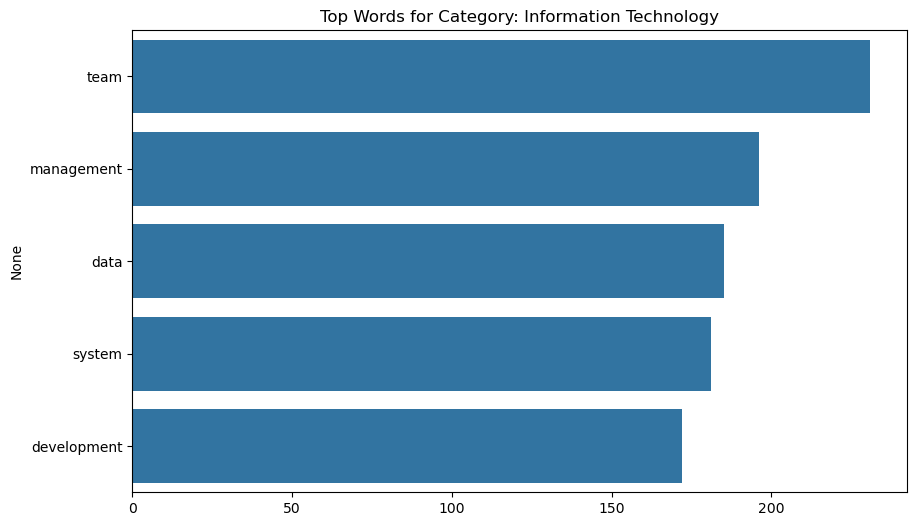

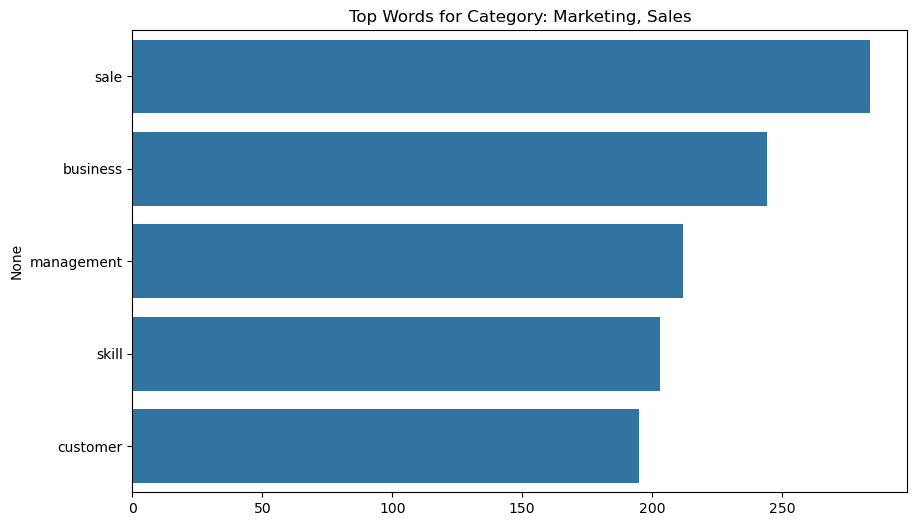

In [21]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Cleaned Job Description'])

# Convert the sparse matrix to a DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate word frequencies per category
word_counts = pd.concat([df['CATEGORY'], X_df], axis=1).groupby('CATEGORY').sum()

# Visualize top words for each category
for category in df['CATEGORY'].unique():
    top_words = word_counts.loc[category].sort_values(ascending=False).head()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_words.values, y=top_words.index)
    plt.title(f'Top Words for Category: {category}')
    plt.show()

Split the data using the 80/20 split into training and testing sets.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned Job Description'], df['CATEGORY'], test_size=0.2, random_state=41, stratify=df['CATEGORY'])

### Feature Engineering

In [23]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Model Development
A *Support Vector Machine (SVM)* algorithm was chosen for the text classification model due to its effectiveness in high-dimensional text data. To address the lack of labeled data, a semi-supervised learning approach known as self-training was employed. The script used is present after the *Conclusion* section on this notebook and labeled as ***Supplementary Work B***.

**Labeling Process**
1. Manual Labeling: Initially, 1000 job descriptions were manually labeled using the 16 initial job categories.
2. Filtering Categories: After training the initial model, the top 5 categories were filtered based on frequency.
3. These categories were used in the iterative self-training process.

**Self-Training**
- The manually labeled subset was used to train the SVM model.
- The model was then used to label additional job descriptions.
- The labeled data was reviewed, corrected, and incorporated into the final training/testing set.
- This process was repeated until at least 5,000 records were labeled.

**Hyperparameter Optimization**

*Grid search* was used for hyperparameter optimization to fine-tune the model parameters, ensuring optimal performance. The SVM model was evaluated using standard metrics, including accuracy, precision, recall, and F1-score.

### Hyperparameter tuning

In [24]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 10]}

svm_model = SVC()

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

### Evaluate model

In [25]:
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred)) 

Accuracy: 0.8333333333333334
                                        precision    recall  f1-score   support

         Admin, HR, CS, Office Support       0.75      0.53      0.62        93
                   Finance, Accounting       0.87      0.75      0.80        60
                Information Technology       0.83      0.45      0.59        44
Internships, Fellowships, Scholarships       0.94      0.75      0.83       123
                      Marketing, Sales       0.78      0.73      0.76        49
                                 Other       0.83      0.96      0.89       537

                              accuracy                           0.83       906
                             macro avg       0.83      0.69      0.75       906
                          weighted avg       0.83      0.83      0.82       906



## Conclusion
The iterative self-training approach which gradually improved the model's performance proved effective in leveraging the large unlabeled dataset. Consultation with HR professionals ensured that the categories were meaningful and relevant, enhancing the practical applicability of the model.

The accuracy of text classification algorithms can vary widely depending on the specific application, dataset, and complexity of the task. However, certain benchmarks and expectations exist based on historical performance and research. Industry standards are between *70% and 90%*. Everything above 70% is acceptable as a realistic and valuable model data output.<sup>**1**</sup> With an **accuracy of 83.33%**, the final model demonstrated high accuracy in classifying job descriptions into the predefined categories. 

The weighted average **F1-score is 0.82**, indicating a good balance between precision and recall across all classes.

In summary, the project successfully developed a text classification model for job descriptions, addressing the challenges of data labeling and classification accuracy. The use of SVM and self-training techniques, coupled with expert consultation and thorough preprocessing, resulted in a robust solution that can significantly aid in job classification tasks.

**References**

*1. [Deep Checks](https://deepchecks.com/question/what-is-a-good-accuracy-score-in-machine-learning/#:~:text=Industry%20standards%20are%20between%2070,various%20businesses%20and%20sectors'%20needs.)*

# Supplementary work
The secondary work related to the project included:
1. Web scraping to retrieve the unlabeled data
2. Semi-supervised labelling of the primary data
3. Recategorization of the least populated job categories

The code for each is available below for quick reference. 

## A. Scraping the unlabeled data

In [ ]:
import requests
import unicodedata
import os
import pandas as pd

from bs4 import BeautifulSoup
from urllib.parse import urlparse
from datetime import date
from pathlib import Path

**Normalize Unicode characters**

In [ ]:
def clean_text(text):
    cleaned_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return cleaned_text

**Isolate job description**

In [ ]:
def get_post_body(url, headers):
  response = requests.get(url, headers=headers)

  if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    section = soup.find('section', class_='main-content')

    if section:
      post_article = section.find('article', class_='post-content')
      if post_article:
        # post_container = post_article.find('div', class_='clearfix').text
        post_container = post_article.find('div', class_='clearfix')
        
        if post_container:
          post_container_text =  clean_text(post_container.get_text(separator=" ", strip=True))

          if len(post_container_text) > 10000:
            post_container_text = len(post_container_text)
            
          return post_container_text

**Isolate date**

In [ ]:
def extract_date_from_url(url):
  parsed_url =  urlparse(url)
  
  path_parts = parsed_url.path.split('/')
  
  year = path_parts[1]
  month = path_parts[2]
  day = path_parts[3]
  
  date = f'{year}-{month}-{day}'
  return date

**Retrieve job post records**

In [ ]:
def get_job_postings(url, headers):
  response = requests.get(url, headers=headers)

  if response.status_code == 200:
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.content, 'html.parser')
    section = soup.find('section', class_='main-content')

    if section:
      post_container = section.find('div', class_='col-lg-8')

      job_posts = []
      
      for post in post_container.find_all('div', class_='post-classic'):
        title_heading_element = post.find('h5')

        title = clean_text(title_heading_element.find('a').text.strip())
        link = title_heading_element.find('a').get("href")

        content = get_post_body(link, headers)
        date = extract_date_from_url(link)

        job_posts.append({
          'title': title,
          'link': link,
          'content': content,
          'date': date
        })
      return job_posts
  else:
    return []

**Save job post data by month**

In [ ]:
def aggregate_job_postings():
  headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
  }

  data_folder = Path('data')
  data_folder.mkdir(parents=True, exist_ok=True)

  first_year = 2018
  first_month = 1

  date_today = date.today()
  year_today = date_today.year
  month_today = date_today.month

  base_url = 'https://opportunitiesforyoungkenyans.co.ke'

  jobs_from_all_dates = []
  merged_jobs = []

  for year in range(first_year, year_today + 1):
    if year == year_today:
      last_month = month_today
    else:
      last_month = 12
    
    for month in range(first_month, last_month + 1):
      current_month_url = f'{base_url}/{year}/{month}'
      current_month_url_response = requests.get(current_month_url, headers=headers)
      print(current_month_url)
      if current_month_url_response.status_code == 200:
        for page_count in range(1, 1000):
          page_url = f'{current_month_url}/page/{page_count}'
          page_url_response = requests.get(page_url, headers=headers)
          
          if page_url_response.status_code == 200:
            page_url_soup = BeautifulSoup(page_url_response.content, 'html.parser')
            page_url_body_tag = page_url_soup.body
            
            if page_url_body_tag and 'error404' in page_url_body_tag.get('class', []):
              print(f'Error 404 found on {page_url}. Stopping search.')
              break # Stop searching further pages because if current page is not found then there are no more pages for this date.
            else:
              jobs_per_date = get_job_postings(page_url, headers)
              jobs_from_all_dates.append(jobs_per_date)
              print(f'Found {page_url}')
          else:
            print(f'Failed to retrieve {page_url}. Status code: {page_url_response.status_code}')
            break  # Stop searching further pages on HTTP error
      else:
        print(f'Failed to retrieve {current_month_url}. Status code: {current_month_url_response.status_code}')
        continue  # Stop searching further pages on HTTP error

      print(f'Month {month} over.')

      for jobs in jobs_from_all_dates:
        merged_jobs.extend(jobs)

      file_name = f'job_postings_{month}-{year}.csv'
      file_path = data_folder / file_name 
        
      df = pd.DataFrame(merged_jobs)
      df.to_csv(file_path, index=False)
        
      print(f'{month}-{year} spreadsheet exported')

      merged_jobs = []
      jobs_from_all_dates = []
        
    print(f'Year {year} over.')     

  print(f'Scraping finished.')  

aggregate_job_postings()

**Combine month files into a common CSV file**

In [ ]:
def combine_files():
    data_folder = Path('data')
    data_folder.mkdir(parents=True, exist_ok=True)

    first_year = 2018
    first_month = 1
    
    date_today = date.today()
    year_today = date_today.year
    month_today = date_today.month

    all_dataframes = []
    
    for year in range(first_year, year_today + 1):
        if year == year_today:
            last_month = month_today
        else:
            last_month = 12
        
        for month in range(first_month, last_month + 1):
            file_name = f'job_postings_{month}-{year}.csv'
            file_path = data_folder / file_name
            
            print(f'Reading file: {file_path}')
            
            try:
                df = pd.read_csv(file_path)
                all_dataframes.append(df)
            except FileNotFoundError:
                print(f'File not found: {file_path}')
                continue

    if all_dataframes:
        file_name = 'complete_unlabeled_data.csv'
        file_path = data_folder / file_name

        combined_df = pd.concat(all_dataframes, ignore_index=True)
        combined_df.to_csv(file_path, index=False)
        print('All files have been combined and saved to /data/complete_unlabeled_data.csv')
    else:
        print('No files were found to combine.')

combine_files()

## B. Self-training

In [31]:
def load_training_data():
    data_folder_name = 'data'
    sample_labeled_data_file_name = 'working-unlabeled-data.csv'
    
    sample_labeled_data_file_path = os.path.join(os.getcwd(), data_folder_name, sample_labeled_data_file_name)
    return pd.read_csv(sample_labeled_data_file_path)

original_unlabeled_df = load_training_data()

In [32]:
original_unlabeled_df.shape

(1000, 4)

In [33]:
print(f'Total missing values: {original_unlabeled_df['JOB DESCRIPTION'].isnull().sum()}')

Total missing values: 85


In [34]:
cleaned_unlabeled_df = original_unlabeled_df.dropna(subset=["JOB DESCRIPTION"])
cleaned_unlabeled_df.count()

TITLE              915
LINK               915
JOB DESCRIPTION    915
DATE               915
dtype: int64

In [35]:
unlabeled_df_copy = cleaned_unlabeled_df.copy()
unlabeled_df_copy['Cleaned Job Description'] = unlabeled_df_copy['JOB DESCRIPTION'].apply(preprocess_text, custom_stopwords=custom_stopwords)
unlabeled_df_copy.head()

,TITLE,LINK,JOB DESCRIPTION,DATE,Cleaned Job Description
0,CIC Group Hiring Procurement Assistant,https://opportunitiesforyoungkenyans.co.ke/202...,"Full Time Nairobi Posted on September 21, 2023...",9/22/2023,full time nairobi posted september close septe...
1,"World Bank Group Hiring : Investment Officer, ...",https://opportunitiesforyoungkenyans.co.ke/202...,Welcome to the combined listing of current job...,9/22/2023,welcome combined listing current opening world...
2,KEMRI Hiring In 10 Sections,https://opportunitiesforyoungkenyans.co.ke/202...,KEMRI has built a strong professional team of ...,9/22/2023,kemri built strong professional team employee ...
3,Relationship Manager Wanted,https://opportunitiesforyoungkenyans.co.ke/202...,JOB PURPOSE: RELATIONSHIP MANAGER KIAMBU ROAD...,9/22/2023,purpose relationship manager kiambu road branc...
4,Action Aid Kenya Hiring Local Rights Programme...,https://opportunitiesforyoungkenyans.co.ke/202...,"Grade: E Salary: Kshs. 189,484 per month Contr...",9/22/2023,grade e salary kshs per month contract duratio...


In [36]:
data_folder = Path('data', 'work_in_progress')
data_folder.mkdir(parents=True, exist_ok=True)

In [37]:
unlabeled_features = vectorizer.transform(unlabeled_df_copy['Cleaned Job Description'])

predicted_categories = best_model.predict(unlabeled_features)

unlabeled_df_copy['CATEGORY'] = predicted_categories
unlabeled_df_copy = unlabeled_df_copy.drop(columns=['Cleaned Job Description'])

file_name = 'predicted_categories.csv'
file_path = data_folder / file_name

unlabeled_df_copy.to_csv(file_path, index=False)
print('A new file has been created at /data/predicted_categories.csv')

A new file has been created at /data/predicted_categories.csv


At this point I manually look through each record, correct the wrong ones, feed the corrected data to the primary labeled data, train the model, and repeat with the fresh batch of data.

## C. Recategorizing of labelled data
This code below is to be run once after the top 5 job categories have been identified from the sample labeled data.

In [79]:
def contract_categories(df):
    data = [
        'Hospitality, Tourism', 
        'Education, Training', 
        'Legal, Security, Law Enforcement', 
        'Construction, Artisans, SkilledTrade', 
        'Transport, Logistics', 
        'Healthcare, Medical', 
        'Entertainment, Arts, Sports', 
        'Social Services', 
        'Science, Research', 
        'Media & Communication',
        'Unknown'
    ]

    return df['CATEGORY'].apply(lambda x: 'Other' if x in data else x)

In [80]:
copy_cleaned_labeled_df = cleaned_original_labeled_df.copy()

copy_cleaned_labeled_df['CATEGORY'] = contract_categories(copy_cleaned_labeled_df)
copy_cleaned_labeled_df['CATEGORY'].value_counts()

CATEGORY
Other                                     496
Internships, Fellowships, Scholarships    163
Admin, HR, CS, Office Support             111
Marketing, Sales                           92
Finance, Accounting                        71
Information Technology                     67
Name: count, dtype: int64

In [81]:
copy_cleaned_labeled_df.shape

(1000, 5)

In [82]:
def create_final_labeled_data_file(df):
    data_folder = Path('data')
    data_folder.mkdir(parents=True, exist_ok=True)
    
    file_name = 'final_labeled_data.csv'
    file_path = data_folder / file_name
    
    df.to_csv(file_path, index=False)
    print('A new file has been created at /data/final_labeled_data.csv')

create_final_labeled_data_file(copy_cleaned_labeled_df)

A new file has been created at /data/final_labeled_data.csv
